In [1]:
import pandas as pd
import numpy as np
from functools import reduce
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import requests

## Importando Datos y Dataframe.

In [2]:
files = ['Data/content.csv', 'Data/genres.csv', 'Data/labels.csv', 'Data/reviews.csv', 'Data/years.csv']

### Importamos los archivos .csv a través de la función *df_frames*.

In [3]:
def df_frames(files):
    dframes = []
    for file in files:
        dframes.append(pd.read_csv(file))
    return dframes
print(df_frames(files))

[       reviewid                                            content
0         22703  “Trip-hop” eventually became a ’90s punchline,...
1         22721  Eight years, five albums, and two EPs in, the ...
2         22659  Minneapolis’ Uranium Club seem to revel in bei...
3         22661  Kleenex began with a crash. It transpired one ...
4         22725  It is impossible to consider a given release b...
5         22722  In the pilot episode of “Insecure,” the critic...
6         22704  Rapper Simbi Ajikawo, who records as Little Si...
7         22694  For the last thirty years, Israel’s electronic...
8         22714  Ambient music is a funny thing. As innocuous a...
9         22724  There were innumerable cameos at the Bad Boy F...
10        22715  Lots of drone musicians have been called sound...
11        22745  On 2006’s “That’s Life,” Killer Mike boasted “...
12        22700  “Why so sad?/Don’t feel so bad/Get out of bed,...
13        22720  In January 2016, rapper/actor Yasiin Bey ann

Merge de csv en un único Dataframe.

In [4]:
def dataset(dframes):
    df = reduce(lambda x,y: pd.merge(x,y, on='reviewid', how='outer'), [df_frames(files)[0], df_frames(files)[1], df_frames(files)[2], df_frames(files)[3], df_frames(files)[4]])
    return df

In [5]:
pitch = dataset(df_frames)
pitch.head(10)

,reviewid,content,genre,label,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,year
0,22703,"“Trip-hop” eventually became a ’90s punchline,...",electronic,virgin,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,1998.0
1,22721,"Eight years, five albums, and two EPs in, the ...",metal,hathenter,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,2016.0
2,22659,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,2016.0
3,22659,Minneapolis’ Uranium Club seem to revel in bei...,rock,fashionable idiots,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,2016.0
4,22661,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,2016.0
5,22661,Kleenex began with a crash. It transpired one ...,rock,mississippi,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,2016.0
6,22725,It is impossible to consider a given release b...,electronic,teklife,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,2016.0
7,22722,"In the pilot episode of “Insecure,” the critic...",NaN,rca,insecure (music from the hbo original series),various artists,http://pitchfork.com/reviews/albums/22722-inse...,7.4,0,vanessa okoth-obbo,contributor,2017-01-05,3,5,1,2017,2016.0
8,22704,"Rapper Simbi Ajikawo, who records as Little Si...",rap,age 101,stillness in wonderland,little simz,http://pitchfork.com/reviews/albums/22704-litt...,7.1,0,katherine st. asaph,contributor,2017-01-05,3,5,1,2017,2016.0
9,22694,"For the last thirty years, Israel’s electronic...",electronic,stroboscopic artefacts,tehillim,yotam avni,http://pitchfork.com/reviews/albums/22694-tehi...,7.0,0,andy beta,contributor,2017-01-05,3,5,1,2017,2016.0


## Trabajamos con el Dataframe y limpieza de datos.

- Analizamos si hay columnas nulas y si es así eliminamos las de mayor valor de números nulos.
- Eliminamos columnas que no nos interesan.
- Eliminamos los datos duplicados.
- Renombramos la columna *title* y ordenamos el dataset.
- Con la variable **year**, asignamos los valores nulos a 0 y transformamos la variable a una variable tipo: int64 para eliminar los float. Eliminamos valores de year nulos.
- Con la variable genre hacemos lo mismo, asignamos los valores nulos a 0 y los eliminamos del dataframe.

In [6]:
def cleaning(df):
    null_cols = df.isnull().sum()
    drop_cols = list(null_cols[null_cols > 5000].index)
    data = df.drop(drop_cols, axis=1)
    select_columns = ['content', 'label', 'url', 'best_new_music', 'author', 'pub_date', 'pub_weekday', 'pub_day', 'pub_month', 'pub_year']
    dframe = data.drop(select_columns, axis=1)
    select_columns = ['reviewid', 'genre', 'title', 'artist', 'score', 'year']
    dframe = dframe[select_columns].drop_duplicates()
    dframe = dframe.rename(columns={'title':'album'})
    column_order = ['reviewid', 'artist', 'album', 'year', 'genre', 'score']
    dframe = dframe[column_order]
    dframe['year'] = dframe['year'].fillna(0)
    dframe['year'] = dframe['year'].astype('int64')
    dframe = dframe[dframe.year != 0]
    dframe['genre'] = dframe['genre'].fillna(0)
    dframe = dframe[dframe.genre != 0]
    dframe['album'] = dframe['album'].fillna(0)
    dframe = dframe[dframe.album != 0]
    return dframe

In [7]:
pitch = cleaning(pitch)
pitch.head(20)

,reviewid,artist,album,year,genre,score
0,22703,massive attack,mezzanine,1998,electronic,9.3
1,22721,krallice,prelapsarian,2016,metal,7.9
2,22659,uranium club,all of them naturals,2016,rock,7.3
4,22661,"kleenex, liliput",first songs,2016,rock,9.0
6,22725,taso,new start,2016,electronic,8.1
8,22704,little simz,stillness in wonderland,2016,rap,7.1
9,22694,yotam avni,tehillim,2016,electronic,7.0
10,22714,brian eno,reflection,2017,experimental,7.7
11,22724,the lox,filthy america its beautiful,2016,rap,5.3
12,22715,harry bertoia,clear sounds/perfetta,2016,experimental,8.0


Hacemos lo mismo con la variable album y, al comprobar que ahora hay valores duplicados tanto en reviewid, artist y album, los eliminamos y nos quedamos con el primero.
Seguidamente ordenamos el dataset de manera ascendente en función de la columna **score**.

In [8]:
def sort_dupl(dframe):
    sel_col = ['reviewid', 'artist', 'album']
    df_dupl = dframe.drop_duplicates(sel_col, keep='first')
    df_final = df_dupl.sort_values('score', ascending=False)
    return df_final

In [9]:
pitch = sort_dupl(pitch)
pitch.head(20)

,reviewid,artist,album,year,genre,score
6153,17497,nas,illmatic,1994,rap,10.0
264,22485,bob dylan,blood on the tracks,1975,rock,10.0
11758,13433,the beatles,rubber soul,1965,rock,10.0
11752,13431,the beatles,abbey road,1969,rock,10.0
11748,13432,the beatles,the beatles,1968,rock,10.0
11742,13449,the stone roses,the stone roses,2009,rock,10.0
13977,11376,otis redding,otis blue: otis redding sings soul [collector'...,1965,pop/r&b,10.0
253,22374,public image ltd,metal box,1979,rock,10.0
5004,18517,nirvana,in utero: 20th anniversary edition,1993,rock,10.0
20531,1490,the clash,london calling: 25th anniversary legacy edition,2004,rock,10.0


### Hacemos los bins de score para representarlos gráficamente.

- Pésimo: Notas de 0 a 3.
- Flojo: Notas de 3 a 5.
- Para fans: Notas de 5 a 6.
- Recomendado: Notas de 6 a 8.
- Muy bueno: Notas de 8 a 9.
- Obra maestra: Notas 9/10.

In [10]:
def create_bins(df_final):
    score = df_final['score']
    bins = (0, 3, 5, 6, 8, 9, 10)
    labels = ('Pésimo', 'Flojo', 'Para fans', 'Recomendado', 'Muy bueno', 'Obra maestra')
    groups = pd.cut(score, bins=bins, labels=labels)
    scores = groups.value_counts(sort=False)
    print(scores)
    return df_final

In [11]:
create_bins(pitch).head()

Pésimo            232
Flojo            1009
Para fans        1719
Recomendado     10124
Muy bueno        2223
Obra maestra      346
Name: score, dtype: int64


,reviewid,artist,album,year,genre,score
6153,17497,nas,illmatic,1994,rap,10.0
264,22485,bob dylan,blood on the tracks,1975,rock,10.0
11758,13433,the beatles,rubber soul,1965,rock,10.0
11752,13431,the beatles,abbey road,1969,rock,10.0
11748,13432,the beatles,the beatles,1968,rock,10.0


In [12]:
df_final = create_bins(pitch)

Pésimo            232
Flojo            1009
Para fans        1719
Recomendado     10124
Muy bueno        2223
Obra maestra      346
Name: score, dtype: int64


Filtramos el dataset a sólo los elementos con nota de #10.

In [13]:
def filter_score(df_final): 
    dfx = df_final
    dfx = dfx[dfx['score'] == 10.0]
    pitch = dfx
    return pitch

In [14]:
pitch = filter_score(pitch)
pitch.head(10)

,reviewid,artist,album,year,genre,score
6153,17497,nas,illmatic,1994,rap,10.0
264,22485,bob dylan,blood on the tracks,1975,rock,10.0
11758,13433,the beatles,rubber soul,1965,rock,10.0
11752,13431,the beatles,abbey road,1969,rock,10.0
11748,13432,the beatles,the beatles,1968,rock,10.0
11742,13449,the stone roses,the stone roses,2009,rock,10.0
13977,11376,otis redding,otis blue: otis redding sings soul [collector'...,1965,pop/r&b,10.0
253,22374,public image ltd,metal box,1979,rock,10.0
5004,18517,nirvana,in utero: 20th anniversary edition,1993,rock,10.0
20531,1490,the clash,london calling: 25th anniversary legacy edition,2004,rock,10.0


Imprimimos los diferentes estilos de música que abarcan los álbumes con mayor nota y con *.shape* mostramos el número de elementos.

In [15]:
loved_genres = pitch.genre.value_counts()
loved_genres

rock            51
rap              7
pop/r&b          6
jazz             3
electronic       3
experimental     2
folk/country     1
Name: genre, dtype: int64

In [16]:
pitch.shape

(73, 6)

## Añadimos la API.

Usamos la función *apireq* en la cual tenemos la dirección de la api y el apiKey para obtener el resultado que nos da la api en relación al album en concreto y así obtener el número de **oyentes** del mismo.

In [17]:
def apireq(artist, album):
    key = open(".env").read()
    url = 'http://ws.audioscrobbler.com/2.0/?method=album.getinfo'
    response = requests.get(url+"&api_key={}&artist={}&album={}&format=json".format(key, artist, album))
    res = response.json()
    return res

In [18]:
def apiloop():
    artist = list(pitch['artist'])
    album = list(pitch['album'])
    listeners = []
    for i in range(len(album)):
        answer = apireq(artist[i], album[i])
        try:
            listeners.append(answer['album']['listeners'])
            #print(answer['album']['listeners'])
        except:
            listeners.append('no data')
            #print(answer, 'Este artista no tiene el álbum en last.fm')
    dictionary = {'album': album, 'listeners_lastfm': listeners}
    answer = pd.DataFrame(dictionary)
    return answer
    
answer = apiloop()
answer

,album,listeners_lastfm
0,illmatic,733865
1,blood on the tracks,402853
2,rubber soul,690406
3,abbey road,1049330
4,the beatles,350682
5,the stone roses,723313
6,otis blue: otis redding sings soul [collector'...,174795
7,metal box,no data
8,in utero: 20th anniversary edition,97
9,london calling: 25th anniversary legacy edition,404


In [19]:
def apimerge(pitch, answer):
    final = pd.merge(pitch, answer, on='album')
    final = final[final.listeners_lastfm != 'no data']
    final['listeners_lastfm'] = final['listeners_lastfm'].astype('int64')
    final['listeners_lastfm'].dtype
    final = final.sort_values(by='listeners_lastfm', ascending=False)
    return final
final = apimerge(pitch, answer)
final.head(20)

,reviewid,artist,album,year,genre,score,listeners_lastfm
66,6656,radiohead,kid a,2000,rock,10.0,1433105
54,14880,kanye west,my beautiful dark twisted fantasy,2010,rap,10.0,1079388
3,13431,the beatles,abbey road,1969,rock,10.0,1049330
62,5758,neutral milk hotel,in the aeroplane over the sea,1998,rock,10.0,955159
14,17499,fleetwood mac,rumours,1977,rock,10.0,872095
72,11624,joy division,unknown pleasures,1979,rock,10.0,851705
19,13435,the beatles,sgt. pepper's lonely hearts club band,1967,rock,10.0,831040
18,13434,the beatles,revolver,1966,rock,10.0,776857
0,17497,nas,illmatic,1994,rap,10.0,733865
5,13449,the stone roses,the stone roses,2009,rock,10.0,723313


Guardamos el dataframe.

In [20]:
def savecsv (final):
    final.to_csv('pipelines_pitchfork.csv')

## ¡Hacemos gráficos!

Ejecutamos la función *plt_score* para graficar el ranking de álbumes según la revista a partir de los bins.

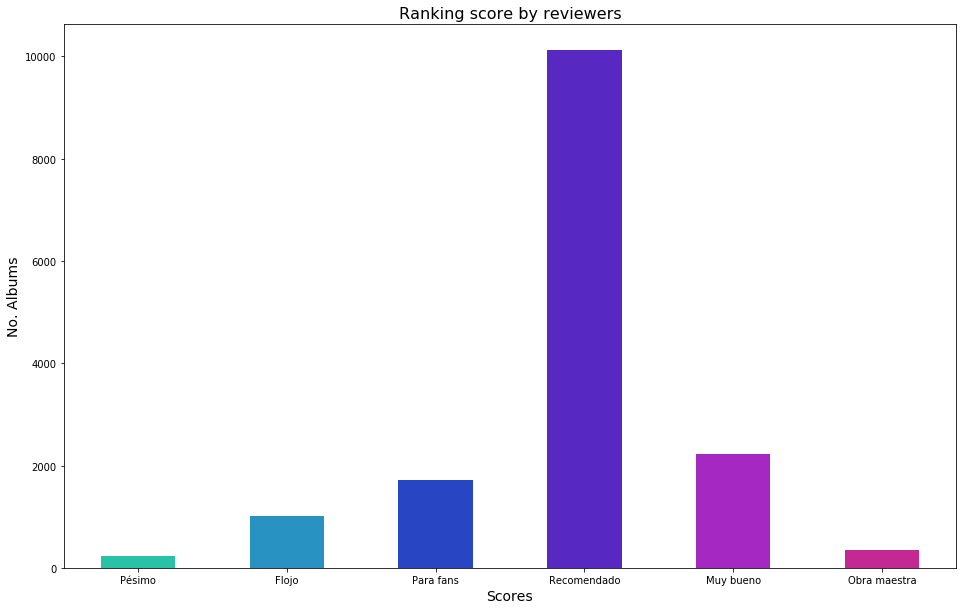

In [21]:
def plt_score(df_final):
    score = df_final['score']
    bins = (0, 3, 5, 6, 8, 9, 10)
    labels = ('Pésimo', 'Flojo', 'Para fans', 'Recomendado', 'Muy bueno', 'Obra maestra')
    groups = pd.cut(score, bins=bins, labels=labels)
    scores = groups.value_counts(sort=False)
    colors = ('#28C3A6', '#2893C3', '#2845C3', '#5828C3', '#A628C3', '#C32893')
    ax = scores.plot.bar(rot=0, color=colors, figsize=(16,10))
    plt.title("Ranking score by reviewers", fontsize=16)
    plt.ylabel('No. Albums', fontsize=14)
    plt.xlabel('Scores', fontsize=14)
    plt.savefig('rankingscore.png')
    return plt.show()
ranking_score = plt_score(df_final)

Usando la función *plt_genre*, creamos un gráfico de barras para analizar los géneros preferidos por la revista Pitchfork en función las reviews con nota 10.

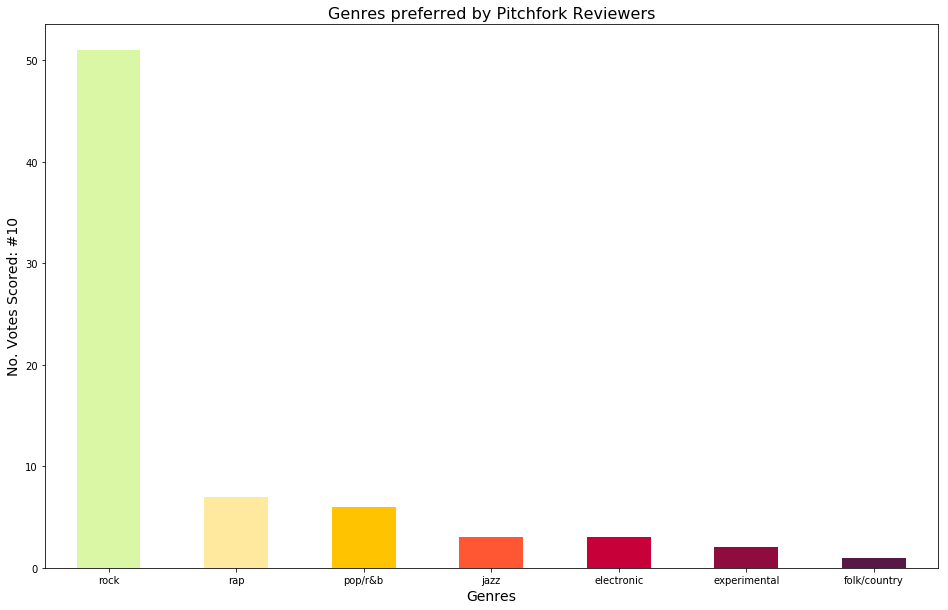

In [22]:
def plt_genre(pitch):
    loved_genres = pitch.genre.value_counts()
    colors = ('#DAF7A6', '#FFE99F', '#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845')
    ax = loved_genres.plot.bar(rot=0, color=colors, figsize=(16,10))
    plt.title("Genres preferred by Pitchfork Reviewers", fontsize=16)
    plt.ylabel('No. Votes Scored: #10', fontsize=14)
    plt.xlabel('Genres', fontsize=14)
    plt.savefig('genrespreferred')
    return plt.show()

genres_pref = plt_genre(pitch)